In [4]:
import sys
sys.path.append('src')

In [5]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dropout
from scipy.signal import savgol_filter
from keras.optimizers import Adam
import scipy.stats as stats

In [7]:
from ppopt.plot import parametric_plot
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from ppopt.mplp_program import MPLP_Program
from ppopt.mpqp_program import MPQP_Program
from energiapy.components import *
from energiapy.model.solve import solve
from energiapy.plot import *
from energiapy.model.formulate import formulate, Constraints, Objective, ModelClass
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.utils.math_utils import normalize, min_max
from itertools import product
from matplotlib import rc

In [8]:
# df = pandas.read_csv('../data/ercot.csv')
# # df = pandas.read_csv('ercot.csv')

# df['Datetime'] = pandas.to_datetime(df['Unnamed: 0'])
# df = df.drop('Unnamed: 0', axis=1)
# df = df.set_index('Datetime')
# df = df.resample('H').mean()
# df

coord_houston = (29.56999969482422, -95.05999755859375)
weather_houston = pandas.read_csv('data/weather_houston.csv', index_col=0)
weather_houston.index = pandas.to_datetime(weather_houston.index, utc=True)

solar = solar_power_output(data=weather_houston, coord=coord_houston, sam='cecmod', module_params='Canadian_Solar_Inc__CS5P_220M',
                           inverter='cecinverter', inverter_params='ABB__MICRO_0_25_I_OUTD_US_208__208V_',
                           temperature_params='open_rack_glass_glass', aoi_model='no_loss', ac_model='sandia', spectral_model='no_loss')

wind = wind_power_output(data=weather_houston, roughness_length=0.1, turbine_type='V100/1800', hub_height=92,
                         wind_speed_model='logarithmic', density_model='ideal_gas', temperature_model='linear_gradient',
                         power_output_model='power_coefficient_curve', density_correction=True, obstacle_height=0,
                         observation_height=10)

# Get [hourly power demand data](https://www.ercot.com/gridinfo/load/load_hist)  for Houston from ERCOT Coastal region
ercot = pandas.read_csv('data/ercot.csv', index_col=0)
ercot.index = pandas.to_datetime(ercot.index, utc=True)
# random missing value
ercot.loc['2016-11-06 23:00:00'] = ercot.loc['2016-11-06 22:00:00']
ercot.columns = ['Value']
demand = ercot
index = demand.index

FileNotFoundError: [Errno 2] No such file or directory: 'data/weather_houston.csv'

In [291]:
solar = normalize(solar)
wind = normalize(wind)
demand = normalize(demand)

solar = pandas.DataFrame(data=solar, index=index)
# solar.index = solar.index.tz_localize(None)
wind = pandas.DataFrame(data=wind, index=index)
# wind.index = wind.index.tz_localize(None)
demand = pandas.DataFrame(data=demand, index=index)

In [292]:
# window_size = 30
# polynomial_degree = 2
# smoothed_data = savgol_filter(df['COAST'], window_size, polynomial_degree)
# filtered_data = pandas.DataFrame({'COAST': smoothed_data}, index=df.index)
# filtered_data['COAST'] = np.log(filtered_data['COAST'])
# filtered_data = filtered_data.dropna()
# filtered_data.plot()

In [293]:
wind

0
2016-01-01 00:00:00+00:00  0.336198
2016-01-01 01:00:00+00:00  0.324577
2016-01-01 02:00:00+00:00  0.313239
2016-01-01 03:00:00+00:00  0.324577
2016-01-01 04:00:00+00:00  0.399033
...                             ...
2020-12-31 19:00:00+00:00  0.900710
2020-12-31 20:00:00+00:00  0.910840
2020-12-31 21:00:00+00:00  0.925977
2020-12-31 22:00:00+00:00  0.922240
2020-12-31 23:00:00+00:00  0.914467

[43800 rows x 1 columns]

In [302]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


data = wind.values
dataset = data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

look_back = 150
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

learning_rate = 0.0005                                  # Smaller the learning rate, provides more time to learn the behaviour of the data
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))        # Number of neurons = 128
model.add(Dropout(0.10))                                # Percentage of data ignored to avoid overfitting
model.add(Dense(1))                                     # Number of output layer
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

history = model.fit(trainX, trainY, epochs=200, batch_size=240,
                    verbose=1, validation_data=(testX, testY))

Epoch 1/200


c:\Users\harsh1310\TXpower\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0371 - val_loss: 0.0100
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 11/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 12/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

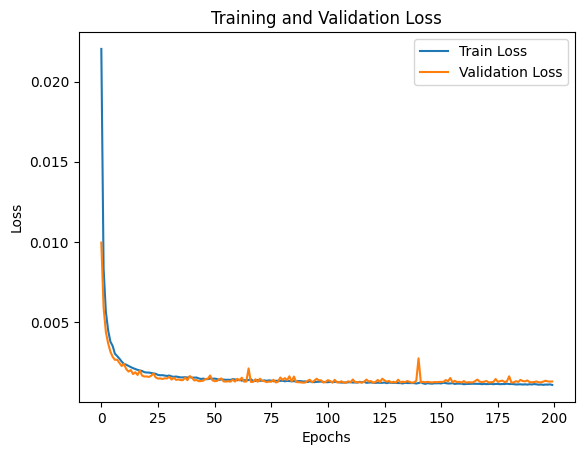

In [303]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
Train Score: 0.05 RMSE
Test Score: 0.06 RMSE
testPredictions:
[[1.0357537]
 [1.0477067]
 [1.0526447]
 ...
 [2.3340654]
 [2.313903 ]
 [2.320187 ]]


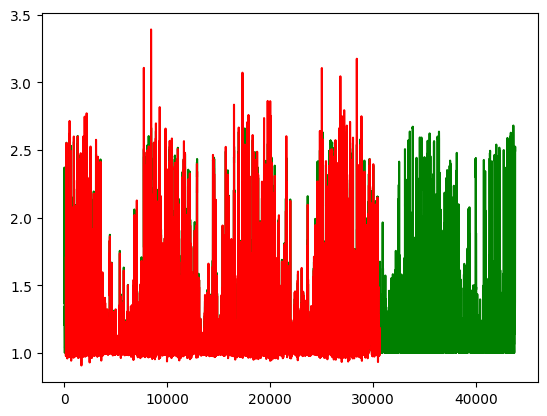

In [304]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = np.exp(trainPredict)
trainY = scaler.inverse_transform([trainY])
trainY = np.exp(trainY)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.exp(testPredict)
testY = scaler.inverse_transform([testY])
testY = np.exp(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2) +
                1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(np.exp(scaler.inverse_transform(dataset)), color='green')
plt.plot(trainPredictPlot, color='red')

print('testPredictions:')
print(testPredict)

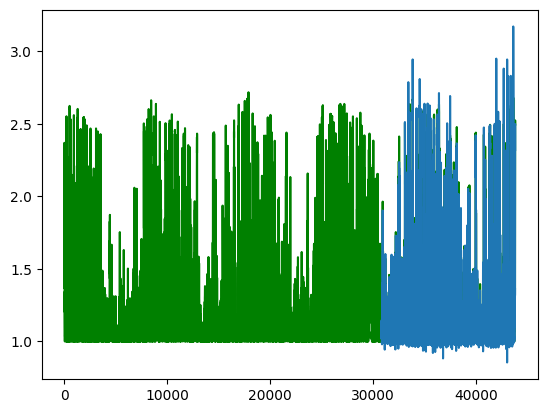

In [305]:
plt.plot(np.exp(scaler.inverse_transform(dataset)), color='green')
plt.plot(testPredictPlot)
plt.show()

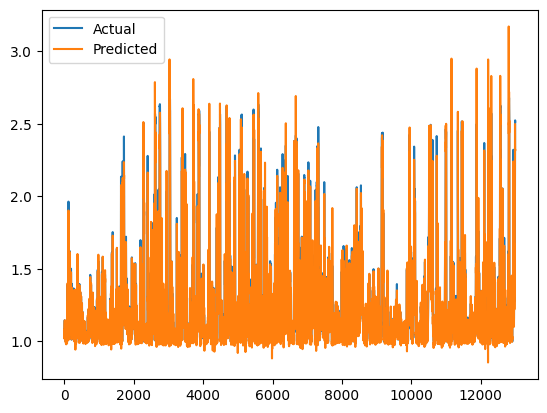

In [306]:
plt.plot(testY.flatten(), label='Actual')
plt.plot(testPredict, label='Predicted')
plt.legend()
plt.show()

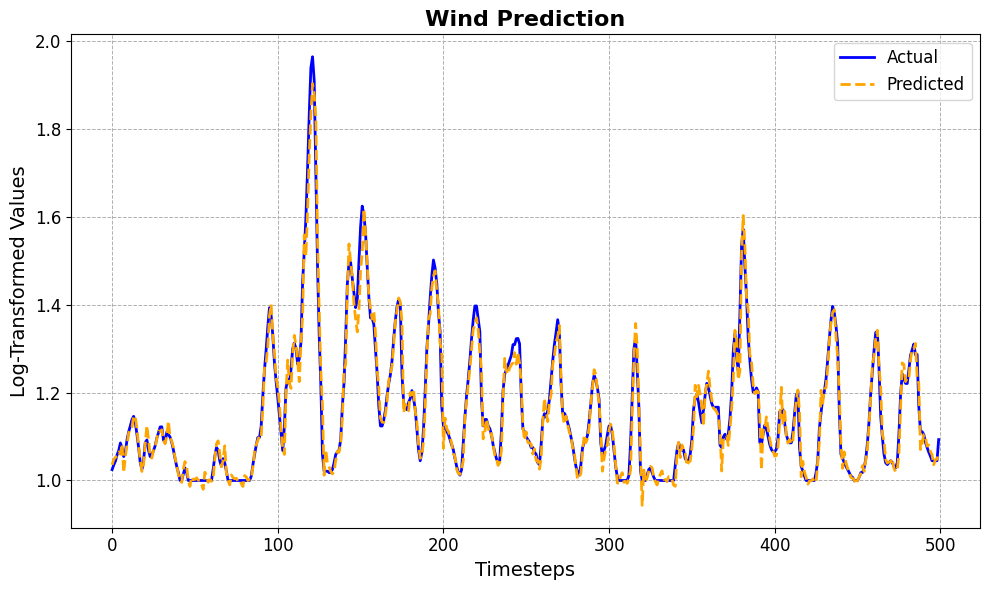

In [310]:
# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility

# Plot the actual values and predictions
plt.plot(testY.flatten()[:500], label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(testPredict[:500], label='Predicted', color='orange', linestyle='--', linewidth=2)

# Set title and axis labels
plt.title('Wind Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Log-Transformed Values', fontsize=14)

# Apply log scale to y-axis
# plt.yscale('log')

# Add grid for better readability
plt.grid(True, which="both", ls="--", linewidth=0.7)

# Add legend with some styling
plt.legend(loc='upper right', fontsize=12)

# Customize ticks for better clarity
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Ensures everything fits nicely
plt.show()

In [27]:
rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('RMSE:', rmse)
mape = np.mean(np.abs((testY[0] - testPredict[:, 0]) / testY[0])) * 100
print('MAPE:', mape)
r2 = r2_score(testY[0], testPredict[:, 0])
print('R-squared:', r2)


def mda(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    mda_value = correct_directions / (len(actual_direction) - 1)
    return mda_value


mda_value = mda(testY[0], testPredict[:, 0])
print('MDA:', mda_value)

RMSE: 0.016487277708395493
MAPE: 0.7111452460259623
R-squared: 0.9974043074109376
MDA: 0.9288574068370804


In [28]:
# Prepare input for predicting future values
last_sequence = dataset[-look_back:]
num_predictions = 24

predicted_values = []

for _ in range(num_predictions):
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    predicted_value = model.predict(last_sequence_reshaped)
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_value[0])

# Invert the predictions back to the original scale
predicted_values = np.exp(scaler.inverse_transform([predicted_values]))
# Print the predicted values
print(predicted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[1.28419246 1.26525412 1.2510384  1.24628222 1.25067859 1.26920354
  1.29988866 1.32479293 1.34864498

In [29]:
# Assuming the last date in df is the latest date
start_date = pandas.to_datetime(demand.index[-1]) + pandas.DateOffset(days=1)
end_date = start_date + pandas.DateOffset(days=num_predictions-1)
future_dates = pandas.date_range(start=start_date, end=end_date)
predicted_values = np.reshape(predicted_values, (num_predictions,))
predicted_df = pandas.DataFrame(
    predicted_values, index=future_dates, columns=['Predicted'])
predicted_df

Predicted
2021-01-01 23:00:00+00:00   1.284192
2021-01-02 23:00:00+00:00   1.265254
2021-01-03 23:00:00+00:00   1.251038
2021-01-04 23:00:00+00:00   1.246282
2021-01-05 23:00:00+00:00   1.250679
2021-01-06 23:00:00+00:00   1.269204
2021-01-07 23:00:00+00:00   1.299889
2021-01-08 23:00:00+00:00   1.324793
2021-01-09 23:00:00+00:00   1.348645
2021-01-10 23:00:00+00:00   1.369967
2021-01-11 23:00:00+00:00   1.384744
2021-01-12 23:00:00+00:00   1.390113
2021-01-13 23:00:00+00:00   1.386393
2021-01-14 23:00:00+00:00   1.379270
2021-01-15 23:00:00+00:00   1.367238
2021-01-16 23:00:00+00:00   1.350189
2021-01-17 23:00:00+00:00   1.339210
2021-01-18 23:00:00+00:00   1.357558
2021-01-19 23:00:00+00:00   1.376301
2021-01-20 23:00:00+00:00   1.359054
2021-01-21 23:00:00+00:00   1.332133
2021-01-22 23:00:00+00:00   1.307283
2021-01-23 23:00:00+00:00   1.278983
2021-01-24 23:00:00+00:00   1.250470

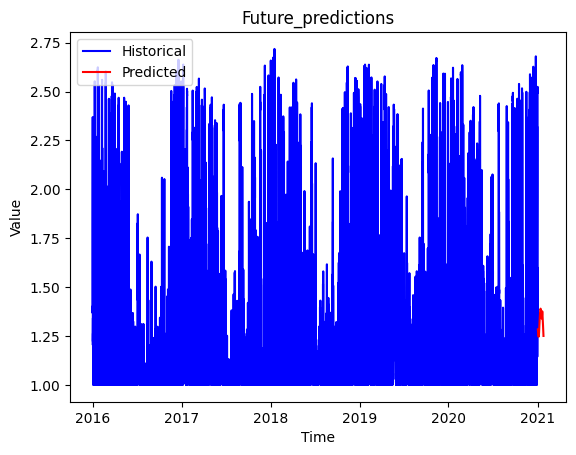

In [30]:
plt.plot(demand.index, np.exp(wind), color='blue', label='Historical')
plt.plot(predicted_df.index,
         predicted_df['Predicted'], color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Future_predictions')
plt.legend()
plt.show()

In [31]:
# model.save('C:\\Users\\Dell\\Desktop\\demand.h5')

In [32]:
def calculate_confidence_interval(predictions, standard_error, confidence_level=0.95):
    """Calculates the confidence interval for a given set of predictions.

    Args:
      predictions: A list of predictions.
      standard_error: The standard error of the predictions.
      confidence_level: The desired confidence level.

    Returns:
      A list of confidence intervals, where each confidence interval is a tuple of
      (lower bound, upper bound).
    """

    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    confidence_intervals = []

    for prediction in predictions:
        lower_bound = prediction - z_score * standard_error
        upper_bound = prediction + z_score * standard_error
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals


def create_confidence_intervals_df(confidence_intervals, predicted_df):
    """
    Create a DataFrame from confidence intervals.

    Parameters:
    - confidence_intervals (list or array-like): The confidence intervals data.
    - predicted_df (DataFrame): The DataFrame with suitable index.

    Returns:
    - DataFrame: The resulting DataFrame with columns 'lower_bound' and 'upper_bound'.
    """
    dt = pandas.DataFrame(confidence_intervals, columns=[
                          'lower_bound', 'upper_bound'])
    dt.index = predicted_df.index
    return dt

In [33]:
std_p = np.std(predicted_values)
std_error = std_p/np.sqrt(num_predictions)
ci_95 = calculate_confidence_interval(
    predicted_df['Predicted'], std_error, 0.95)
ci_99 = calculate_confidence_interval(
    predicted_df['Predicted'], std_error, 0.99)
ci_90 = calculate_confidence_interval(
    predicted_df['Predicted'], std_error, 0.90)
ci_85 = calculate_confidence_interval(
    predicted_df['Predicted'], std_error, 0.85)

In [34]:
ci_95 = create_confidence_intervals_df(ci_95, predicted_df)
ci_99 = create_confidence_intervals_df(ci_99, predicted_df)
ci_90 = create_confidence_intervals_df(ci_90, predicted_df)
ci_85 = create_confidence_intervals_df(ci_85, predicted_df)

In [35]:
max_ = max(ci_99['upper_bound'])
predicted_df['Predicted'] = predicted_df['Predicted']/max_
ci_99 = ci_99/max_
ci_95 = ci_95/max_
ci_90 = ci_90/max_
ci_85 = ci_85/max_

In [36]:
# plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
# plt.fill_between(dt.index, dt['lower_bound'], dt['upper_bound'], color='blue', alpha=0.5, label='95% Confidence Interval')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Future_predictions')
# plt.legend()
# plt.show()

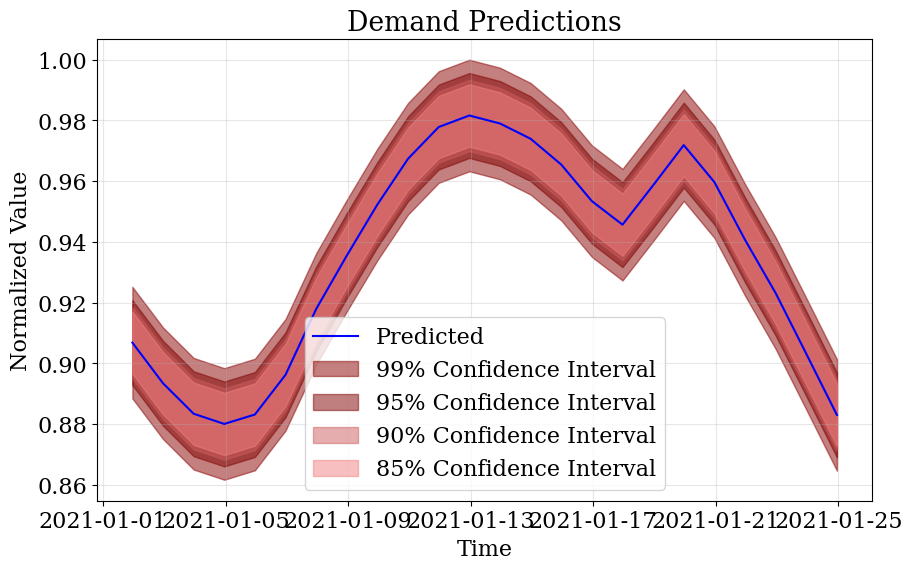

In [37]:
rc('font', **{'family': 'serif',
              'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(predicted_df.index,
        predicted_df['Predicted'], color='blue', label='Predicted')
ax.fill_between(ci_99.index, ci_99['lower_bound'], ci_99['upper_bound'],
                color='darkred', alpha=0.5, label='99% Confidence Interval')
ax.fill_between(ci_95.index, ci_95['lower_bound'], ci_95['upper_bound'],
                color='maroon', alpha=0.5, label='95% Confidence Interval')
ax.fill_between(ci_90.index, ci_90['lower_bound'], ci_90['upper_bound'],
                color='indianred', alpha=0.5, label='90% Confidence Interval')
ax.fill_between(ci_85.index, ci_85['lower_bound'], ci_85['upper_bound'],
                color='lightcoral', alpha=0.5, label='85% Confidence Interval')

# xtick_positions = np.linspace(0, 30, 30)

# plt.xticks(predicted_df.index, list(range(30)), rotation = 45)
plt.legend()
plt.title(f'Demand Predictions')
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.grid(alpha=0.3)
plt.rcdefaults()

In [24]:
# def problem(demand_ci, index_):
#     scales = TemporalScale(discretization_list=[1])

#     Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

#     Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

#     Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND],
#                     varying_bounds  = (demand_ci['lower_bound'][index_],demand_ci['upper_bound'][index_]))#(min(demand['COAST']), 1))

#     H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

#     O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

#     H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

#     Uranium = Resource(name='Uranium', cons_max=1000,
#                    price=42.70/(250/2), basis='kg', label='Uranium')

#     LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  cap_min=100,
#                 storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=30)

#     WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
#                 cap_min=100, label='Wind mill array', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY],
#                 #varying_bounds = (wind_ci['lower_bound'][index_],wind_ci['upper_bound'][index_]))

#     PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
#                 cap_min=100, label='Solar PV', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY],
#                 # varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

#     PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
#               vopex=1.55*10**3, cap_min=100, cap_min = 0, basis = 'tons', label = 'PEM' )

#     ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
#                capex=7988951, fopex=0.04*0.730, vopex=7988, cap_min=100, label='Small modular reactors (SMRs)', block='power_gen')

#     region = Location(name='region', processes={
#                     LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
#     scenario = Scenario(name='example', demand={region: {Power:100}}, network=region, scales=scales, label='example scenario')
#     matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
#     # print(matrix)
#     # return matrix
#     # print(scenario.b_df)
#     print(matrix['no_eq_cons'])
#     return matrix, solve(matrix = matrix, interface = 'native', name = 'results', solver = 'ppopt')

In [25]:
# time_periods = 3
# solution_99 =  [problem(ci_99, index_) for index_ in range(time_periods)]
# solution_95 =  [problem(ci_95, index_) for index_ in range(time_periods)]
# solution_90 =  [problem(ci_90, index_) for index_ in range(time_periods)]
# solution_85 =  [problem(ci_85, index_) for index_ in range(time_periods)]

In [48]:
wind_pred = pandas.read_excel('data/wind_pred.xlsx', index_col=0)
wind_dict = wind_pred['Predicted'].to_dict()
wind_dict

{Timestamp('2021-01-01 00:00:00'): 0.9529033137251812,
 Timestamp('2021-01-01 01:00:00'): 0.9429171138216619,
 Timestamp('2021-01-01 02:00:00'): 0.9183540047757842,
 Timestamp('2021-01-01 03:00:00'): 0.8818503225323776,
 Timestamp('2021-01-01 04:00:00'): 0.8456720180078983,
 Timestamp('2021-01-01 05:00:00'): 0.8187908044569464,
 Timestamp('2021-01-01 06:00:00'): 0.804248649377,
 Timestamp('2021-01-01 07:00:00'): 0.7928012946450304,
 Timestamp('2021-01-01 08:00:00'): 0.7835804324155659,
 Timestamp('2021-01-01 09:00:00'): 0.7637756207209114,
 Timestamp('2021-01-01 10:00:00'): 0.7284245214788794,
 Timestamp('2021-01-01 11:00:00'): 0.6944921128903837,
 Timestamp('2021-01-01 12:00:00'): 0.6871269639367545,
 Timestamp('2021-01-01 13:00:00'): 0.7071164453569582,
 Timestamp('2021-01-01 14:00:00'): 0.7381477142922441,
 Timestamp('2021-01-01 15:00:00'): 0.7609434745008904,
 Timestamp('2021-01-01 16:00:00'): 0.7788825941445917,
 Timestamp('2021-01-01 17:00:00'): 0.7773133401103156,
 Timestamp('20

In [38]:
from energiapy.components.scenario import Scenario
from energiapy.components.location import Location
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.material import Material
from energiapy.components.temporal_scale import TemporalScale

In [247]:
# scales = TemporalScale(discretization_list=[1])

# Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

# Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

# Power = Resource(name='Power', basis='MW', label='Power generated')#, demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND],
#                  #varying_bounds  = (0,1))#(min(demand['COAST']), 1))

# H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

# O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

# H2 = Resource(name='H2', basis='tons', label='Hydrogen')#, demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

# Uranium = Resource(name='Uranium', cons_max=1000,
#                 price=42.70/(250/2), basis='kg', label='Uranium')

# LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  cap_max=200,
#             storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=200)

# WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
#             cap_max=100, label='Wind mill array', basis='MW', varying = [VaryingProcess.UNCERTAIN_CAPACITY],
#             varying_bounds = (0,1))

# PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
#             cap_max=100, label='Solar PV', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY],
#             # varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

# PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
#             vopex=1.55*10**3, cap_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )

# ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
#             capex=7988951, fopex=0.04*0.730, vopex=7988, cap_max=100, label='Small modular reactors (SMRs)', block='power_gen')

# region = Location(name='region', processes={
#                 LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
# scenario = Scenario(name='example', demand={region: {Power:60}}, network=region, scales=scales, label='example scenario')
# matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)

scales = TemporalScale(discretization_list=[1])

Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', label='Power generated', demand=True, varying=[VaryingResource.UNCERTAIN_DEMAND],
                 varying_bounds=(0, 1))
H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

# , varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))
H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand=True)

Uranium = Resource(name='Uranium', cons_max=1000,
                   price=42.70/(250/2), basis='kg', label='Uranium')

LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  cap_max=200,
              storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=200)

WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
             cap_max=70, label='Wind mill array', basis='MW')  # , varying = [VaryingProcess.UNCERTAIN_CAPACITY],
# varying_bounds = (0,1))

PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
             cap_max=100, label='Solar PV', basis='MW')  # , varying = [VaryingProcess.UNCERTAIN_CAPACITY],
# varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
              vopex=1.55*10**3, cap_max=100, cap_min=0, basis='tons', label='PEM')

ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
               capex=7988951, fopex=0.04*0.730, vopex=7988, cap_max=100, label='Small modular reactors (SMRs)', block='power_gen')

region = Location(name='region', processes={
    LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
scenario = Scenario(name='example', demand={
                    region: {Power: 100}}, network=region, scales=scales, label='example scenario')
matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
# print(matrix)
# return matrix
# print(scenario.b_df)

The problem has the following variables:
Resource inventory level (Inv) x 1
Exact resource discharge (Sf) x 0
Uncertain resource discharge (S) x 1
Resources discharge no demand (Snd) x 0
Exact resource availability (Af) x 3
Uncertain resource availability (A) x 0
Implicit resource (I) x 0
Exact resource price (Cf) x 3
Uncertain resource price (C) x 0
Exact process production (Pf) x 4
Uncertain process production (P) x 0
 For a total of 9 (8 fixed, and 1 uncertain)


In [248]:
prog = MPLP_Program(matrix['A'], matrix['b'], matrix['c'], matrix['H'],
                    matrix['CRa'], matrix['CRb'], matrix['F'], equality_indices=list(range(matrix['no_eq_cons'])))

In [249]:
matrix['A'][0][6] = -1
matrix['A'][0][7] = 1

In [250]:
time_periods = 24

In [251]:
prog.display_latex()

$$\min_{x}\left[\begin{matrix}0\\0\\0\\0.3416\\0\\7.988e+03\\1.302e+03\\0\\990.0\end{matrix}\right]^T\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\end{matrix}\right]$$
$$\left[\begin{matrix}1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0\\-1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0\end{matrix}\right]\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}

In [252]:
from scipy.linalg import block_diag
A = block_diag(*[matrix['A'] for x in range(time_periods)])
A.shape

(552, 216)

In [253]:
for i in range(time_periods - 1):
    x_cord = i*9
    y_cord = (i+1)*(23)
    A[y_cord, x_cord] = -1

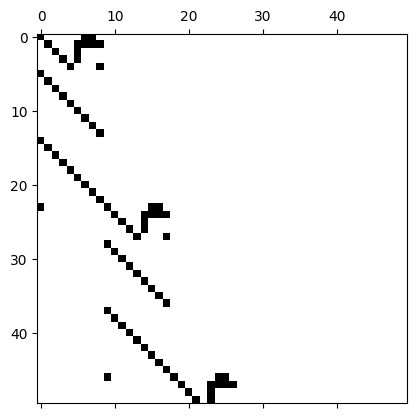

In [254]:
plt.spy(A[:50, :50])

In [255]:
c = np.vstack([matrix['c'] for _ in range(time_periods)])

In [256]:
F = np.vstack([matrix['F'] for _ in range(time_periods)])

In [257]:
b = np.vstack([matrix['b'] for _ in range(time_periods)])

In [258]:
for i in range(time_periods):
    b[23*i+6] = predicted_df.to_numpy()[i]*(-scenario.demand['region']['Power'])
for i in range(time_periods):
    b[23*i+13] = wind_pred.to_numpy()[i]*WF.cap_max

In [259]:
A_t = np.array([[1], [-1]])
b_t = np.array([[6], [0]])

In [260]:
eqs = [[0+i*23, 1+i*23, 2+i*23, 3+i*23, 4+i*23] for i in range(time_periods)]
eqs = sum(eqs, [])

In [261]:
from ppopt.mplp_program import MPLP_Program
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

prog = MPLP_Program(A, b, c, np.zeros((1, time_periods*9)).T,
                    A_t, b_t, F, equality_indices=eqs)

In [262]:
b_t

array([[6],
       [0]])

In [263]:
prog.solver.solvers['lp'] = 'gurobi'
prog.b[0] = 20
prog.process_constraints()

In [264]:
for i in range(24):
    prog.c[0 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[1 + 9*i] = -10 * (1 - 0.0001)**i
    prog.c[2 + 9*i] = 10 * (1 - 0.0001)**i
    prog.c[3 + 9*i] = 10000 * (1 - 0.0001)**i
    # prog.c[4 + 9*i] = 0
    prog.c[5 + 9*i] = 100000 * (1 - 0.0001)**i
    prog.c[6 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[7 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[8 + 9*i] = 0 * (1 - 0.0001)**i

In [265]:
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

In [200]:
prog.solve_theta(np.array([[2]])).active_set, prog.num_constraints()

AttributeError: 'NoneType' object has no attribute 'active_set'

In [147]:
prog.solve_theta(np.array([[2]])).active_set

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 124, 125, 131, 135, 139, 140, 146, 147, 150,
       154, 155, 161, 162, 165, 169, 170, 176, 177, 180, 184, 185, 191,
       192, 195, 199, 200, 206, 207, 210, 214, 215, 221, 222, 225, 229,
       230, 236, 237, 240, 244, 245, 251, 252, 255, 259, 260, 266, 267,
       270, 274, 275, 281, 282, 285, 289, 290, 296, 297, 300, 30

In [266]:
from ppopt.utils.constraint_utilities import is_full_rank

is_full_rank(prog.A[prog.equality_indices])

True

In [315]:
wp = list(wind_pred['Predicted'])


In [320]:
import statistics
3*statistics.stdev(wp) 

0.2744996847790863

In [267]:
theta = np.linspace(0.0001, 5.9999, 100)

In [268]:
sols = [prog.solve_theta(np.array([[t]])) for t in theta]
# sols_obj = [sol.obj.flatten() for sol in sols if sol is not None]
sols_obj = [sol.obj.flatten()[0] if sol is not None else None for sol in sols]

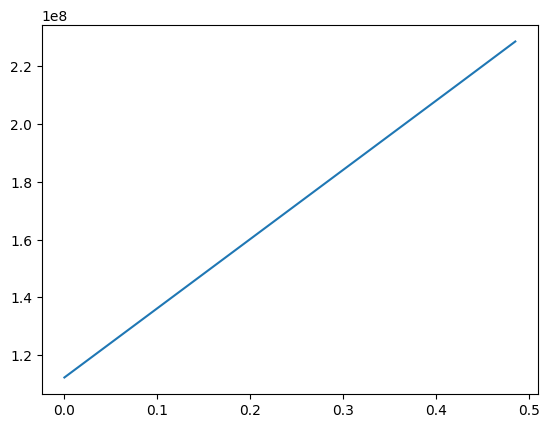

In [270]:
plt.plot(theta, sols_obj)

In [206]:
x = prog.solve_theta(np.array([[2]]))

In [207]:
count = 0
for index, i in enumerate(x.dual):
    if not np.isclose(i, 0):
        count += 1
print(count)

AttributeError: 'NoneType' object has no attribute 'dual'

In [172]:
sol2 = prog.solve_theta(np.array([[2]]))
sol3 = prog.solve_theta(np.array([[2]]))

In [173]:
sol0 = prog.solve_theta(np.array([[0]]))

In [174]:
A = sol3.sol - sol2.sol
b = sol0.sol

In [175]:
A[:9]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [176]:
prog.c.T@(b + A*6)

array([-14441.59003648])

In [177]:
prog.c[:9]

array([[ 0.e+00],
       [-1.e+01],
       [ 1.e+01],
       [ 1.e+04],
       [ 0.e+00],
       [ 1.e+05],
       [ 0.e+00],
       [ 0.e+00],
       [ 0.e+00]])

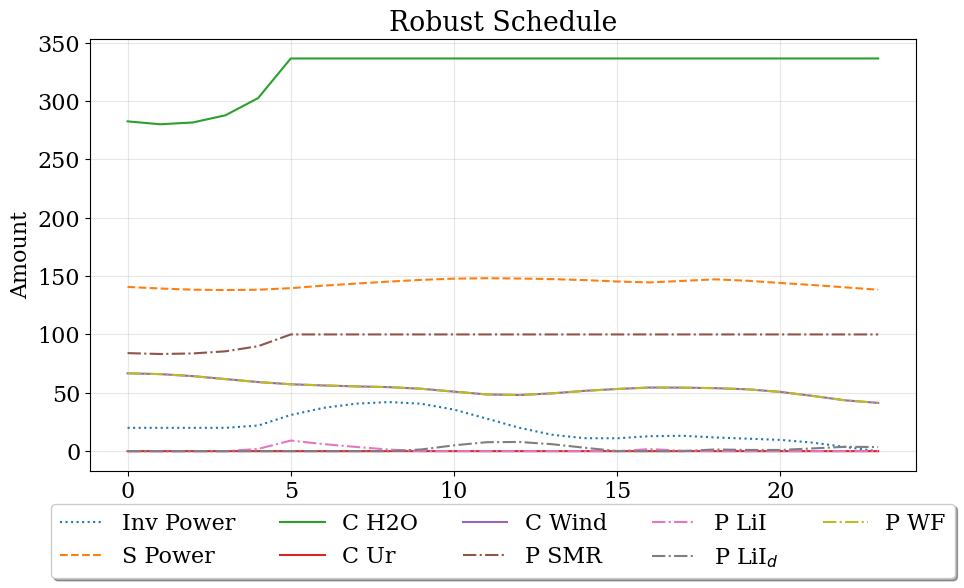

In [274]:
from matplotlib import rc
sol3 = prog.solve_theta(np.array([[0.5]]))
# sol3 = prog.solve_theta(numpy.array([[0.1]]))


# time_sols = sol3.sol.reshape(24, -1)
# plt.subplots(figsize=(20, 10))
# labels = ['Inv','Sale of Power','Cons. H20','Cons. U','Cons. Wind','Prod. Nucluer','Prod. LiIon','Prod. LiIon Discharch','Prod. Windfarm']
# for i in range(9):
#     plt.plot(list(range(24)), time_sols[:,i])
# plt.legend(labels)
# plt.savefig('baba.pdf')

# plt.subplots(figsize=(20, 10))
time_sols = sol3.sol.reshape(24, -1)
labels = ['Inv Power', 'S Power', 'C H2O', 'C Ur',
          'C Wind', 'P SMR', 'P LiI', r'P LiI$_d$', 'P WF']
lines = ['dotted', 'dashed', 'solid', 'solid', 'solid',
         'dashdot', 'dashdot', 'dashdot', 'dashdot']
annot = ['', '', 'H2O', 'Ur', 'Wind', 'SMR', 'LiI', 'LiI_d', 'WF']
# for i in range(9):
#     plt.plot(list(range(24)), time_sols[:,i])
# plt.legend(labels)

# plt.savefig('baba_nominal.pdf')
rc('font', **{'family': 'serif',
              'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10, 6))
# ax.scatter(normalize(obj3), normalize(obj4), s=10, color='steelblue')
for i in range(9):
    ax.plot(list(range(24)), time_sols[:, i],
            label=labels[i], linestyle=lines[i])
    # ax.annotate(annot[i], xy = (23, time_sols[:,i][23]))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
# ax.set_xticklabels(list(range(24)))

# xtick_positions = np.linspace(0, 24, 24)

# plt.xticks(list(range(24)), list(range(24)), rotation = 45)
# plt.legend()
plt.title(f'Robust Schedule')
plt.xlabel("Hour")
plt.ylabel("Amount")
plt.grid(alpha=0.3)
plt.rcdefaults()
plt.tight_layout()
plt.savefig('baba_6.pdf')
plt.savefig('baba_6.png', dpi=400)